In [1]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import svm, datasets, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, average_precision_score, brier_score_loss, classification_report
from sklearn.metrics import cohen_kappa_score, f1_score, hamming_loss, log_loss, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression


%run 'utils/imports_1.ipynb'
%run 'utils/arff.ipynb'
%run 'utils/arffconverter.ipynb'
%run 'utils/arffcrossvalidation.ipynb'

#### TODO:
* Uzupełnienie wszystkich wykresów o zrobione sieci bayesowskie
* Porównanie algorytmów w sieciach bayesowskich w zależności od wielkości data-setu
* Wykres świecowy dla konkretnego datasetu - tego, co najlepiej wypadł w poprzednim porównaniu - czyli porównanie na jednym wykresie wszystkich algorytmów
* [?] Wykres par
* [?] Wykres liniowy

# 1. Zależność wielkości zbioru testowego od poprawności klasyfikacji

In [3]:
class ComputeForArff(object):
    def __init__(self, classifier, arff_path, splits):
        self.classifier = classifier
        self.arff_path = arff_path
        self.splits = splits
        self.seed = 7
    
    def compute_result(self):
        data = load_arff(self.arff_path)
        
        kfold = model_selection.KFold(n_splits=self.splits, random_state=self.seed)
        return cross_val_score(self.classifier, data.data, data.target, cv=kfold)

In [6]:
class ComputeBayesianNetworkStats(object):
    def __init__(self, classifier, arff_array):
        self.classifier = classifier
        self.arff_array = arff_array
        
    def compute_stats_dataframe(self):
        bn_data = dict()
        for i, path in enumerate(self.arff_array):
            print(i)
            bn_values = self.compute_stats(path)
            bn_data[labels[i]] = bn_values
        
        return pd.DataFrame(data=bn_data, index=["MAE", "MSE", "CKS", "HL"])
        
    def compute_stats(self, arff_path):
        attributes, a, b = ARFFLoader(arff_path).load_attributes_and_samples(8, 100)
        y, predicted = KFoldCrossValidation(arff_path, 8).predict(self.classifier)

        final_predicted = []
        for pred in predicted:
            for i, t in enumerate(attributes[0]['states']):
                if t == pred:
                    final_predicted.append(i)
                    continue

        final_y = []
        for pred in y:
            for i, t in enumerate(attributes[0]['states']):
                if t == pred:
                    final_y.append(i)
                    continue      

        MAE = mean_absolute_error(final_y, final_predicted)
        MSE = mean_squared_error(final_y, final_predicted)
        CKS = cohen_kappa_score(final_y, final_predicted)
        HL = hamming_loss(final_y, final_predicted)
        
        return [MAE, MSE, CKS, HL]

In [9]:
class ComputeStatisticsForArff(object):
    def __init__(self, classifier, arff_path):
        self.classifier = classifier
        self.arff_path = arff_path
    
    def compute_result(self):
        data = load_arff(self.arff_path)
        X = data.data
        y = data.target
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123456)
        self.classifier.fit(X_train, y_train)
        predicted_values = self.classifier.predict(X_test)
        
        MAE = mean_absolute_error(y_test, predicted_values)
        MSE = mean_squared_error(y_test, predicted_values)
        CKS = cohen_kappa_score(y_test, predicted_values)
        HL = hamming_loss(y_test, predicted_values)
        
        return [MAE, MSE, CKS, HL]

In [33]:
nursery_paths = ['data/comparison/nursery_100.arff',
                'data/comparison/nursery_200.arff',
                'data/comparison/nursery_400.arff',
                'data/comparison/nursery_800.arff', 
                'data/comparison/nursery_1000.arff',
                'data/comparison/nursery_2000.arff',
                'data/comparison/nursery_4000.arff',
                'data/comparison/nursery_8000.arff',
                'data/comparison/nursery_12960.arff']

best_arff = 5
data = load_arff(nursery_paths[best_arff])

labels = [100, 200, 400, 800, 1000, 2000, 4000, 8000, 12960]

sns.set_style("whitegrid")
sns.set_palette(sns.light_palette((210, 90, 60), input="husl"))

#### 1. SVM

In [69]:
SVM_df = pd.DataFrame()
   
for i, nursery in enumerate(nursery_paths): 
    df_temp = pd.DataFrame({"value": ComputeForArff(SVC(kernel='linear', C=50), nursery, 10).compute_result()})
    df_temp['size'] = labels[i]
    df_temp['kernel'] = "linear"
    SVM_df = SVM_df.append(df_temp)

for i, nursery in enumerate(nursery_paths): 
    df_temp = pd.DataFrame({"value": ComputeForArff(SVC(kernel='rbf', C=50), nursery, 10).compute_result()})
    df_temp['size'] = labels[i]
    df_temp['kernel'] = "rbf"
    SVM_df = SVM_df.append(df_temp)

In [70]:
rbf_data = dict()
linear_data = dict()
for i, path in enumerate(nursery_paths):
    linear_values = ComputeStatisticsForArff(SVC(kernel='linear', C=50), path).compute_result()
    linear_data[labels[i]] = linear_values
    
    rbf_values = ComputeStatisticsForArff(SVC(kernel='rbf', C=50), path).compute_result()
    rbf_data[labels[i]] = rbf_values
    
rbf_kernel_df = pd.DataFrame(data=rbf_data, index=["MAE", "MSE", "CKS", "HL"])
linear_kernel_df = pd.DataFrame(data=linear_data, index=["MAE", "MSE", "CKS", "HL"])

Text(0.5,1,'SVM, kernel = {linear, rbf}, 10-fold cross validation, nursery.arff')

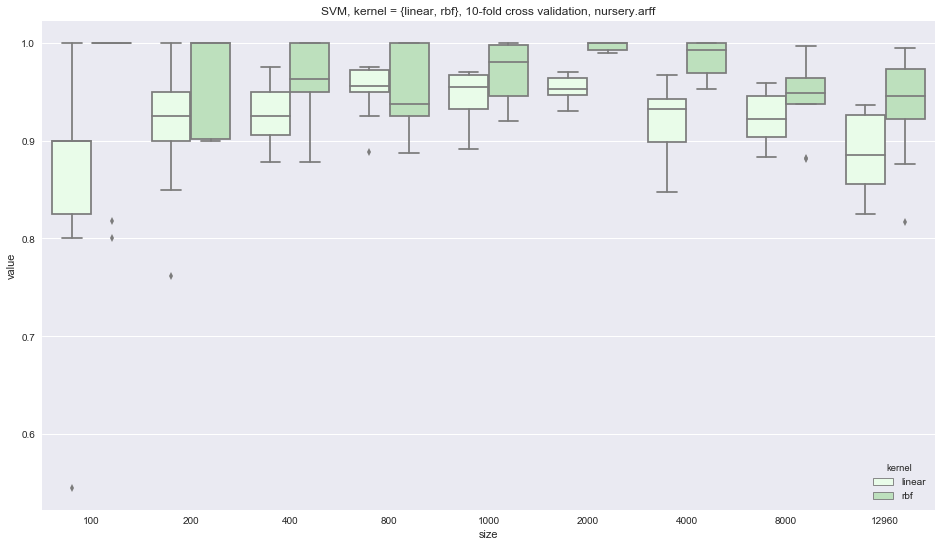

In [116]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.boxplot(x="size", y="value", hue="kernel", data=SVM_df, palette=sns.light_palette("green")).set_title("SVM, kernel = {linear, rbf}, 10-fold cross validation, nursery.arff")

In [148]:
rbf_kernel_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,3.921569,2.970297,1.492537,0.997506,0.399202,0.599401,0.699650,0.574856,0.246914
MSE,3.921569,2.970297,1.492537,0.997506,0.399202,0.599401,0.699650,0.574856,0.246914
CKS,93.985849,94.826703,97.397609,98.091839,99.268581,98.888478,98.900192,99.138578,99.637422
HL,39.215686,29.702970,14.925373,9.975062,3.992016,5.994006,6.996502,5.748563,2.469136


In [149]:
linear_kernel_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,7.843137,7.920792,8.955224,3.491272,4.391218,3.796204,6.446777,7.248188,9.012346
MSE,7.843137,7.920792,10.945274,3.491272,4.790419,3.796204,6.446777,7.498125,9.043210
CKS,88.153310,86.015922,86.068272,93.181929,92.154362,92.892458,89.724696,89.262398,86.735830
HL,78.431373,79.207921,79.601990,34.912718,41.916168,37.962038,64.467766,71.232192,89.969136


#### 2. KNN

In [34]:
KNN_df = pd.DataFrame()
   
for i, nursery in enumerate(nursery_paths): 
    df_temp = pd.DataFrame({"value": ComputeForArff(KNeighborsClassifier(5, weights='distance'), nursery, 10).compute_result()})
    df_temp['size'] = labels[i]
    df_temp['knn'] = "5"
    KNN_df = KNN_df.append(df_temp)

for i, nursery in enumerate(nursery_paths): 
    df_temp = pd.DataFrame({"value": ComputeForArff(KNeighborsClassifier(25, weights='distance'), nursery, 10).compute_result()})
    df_temp['size'] = labels[i]
    df_temp['knn'] = "25"
    KNN_df = KNN_df.append(df_temp)

In [35]:
k_5_data = dict()
k_25_data = dict()
for i, path in enumerate(nursery_paths):
    k_5_values = ComputeStatisticsForArff(KNeighborsClassifier(5, weights='distance'), path).compute_result()
    k_5_data[labels[i]] = k_5_values
    
    k_25_values = ComputeStatisticsForArff(KNeighborsClassifier(25, weights='distance'), path).compute_result()
    k_25_data[labels[i]] = k_25_values
    
k_5_df = pd.DataFrame(data=k_5_data, index=["MAE", "MSE", "CKS", "HL"])
k_25_df = pd.DataFrame(data=k_25_data, index=["MAE", "MSE", "CKS", "HL"])

Text(0.5,1,'K-NN, K={5, 25}, 10-fold cross validation, nursery.arff')

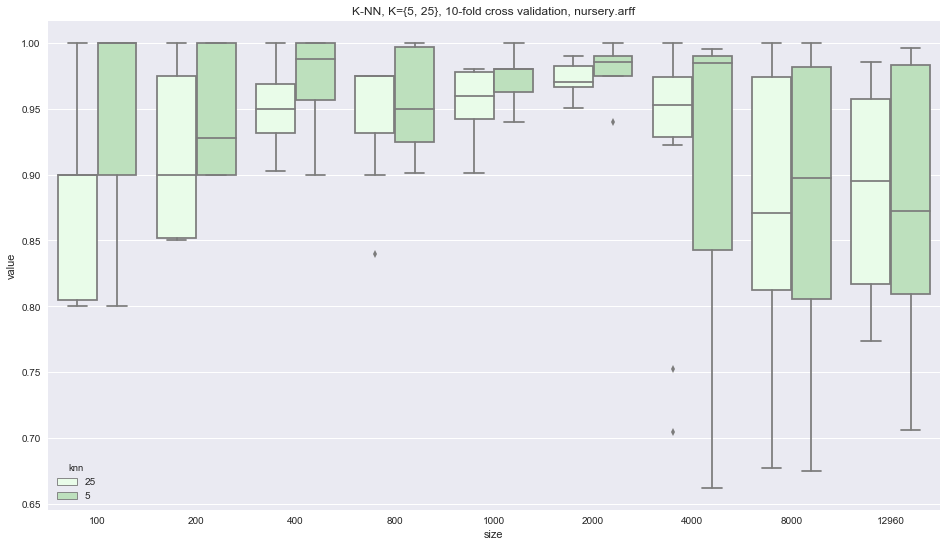

In [117]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.boxplot(x="size", y="value", hue="knn", data=KNN_df, palette=sns.light_palette("green")).set_title('K-NN, K={5, 25}, 10-fold cross validation, nursery.arff')

In [44]:
k_5_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,0.254902,0.099010,0.099502,0.087282,0.071856,0.061938,0.064968,0.052237,0.043827
MSE,0.450980,0.118812,0.109453,0.182045,0.147705,0.139860,0.130935,0.077731,0.062346
CKS,0.719609,0.843005,0.826259,0.892013,0.913785,0.932086,0.924901,0.932143,0.942762
HL,0.176471,0.089109,0.094527,0.054863,0.045908,0.035964,0.046977,0.044989,0.038889


In [45]:
k_25_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,0.333333,0.227723,0.154229,0.077307,0.105788,0.038961,0.059470,0.056736,0.047377
MSE,0.529412,0.425743,0.184080,0.127182,0.217565,0.044955,0.069465,0.056736,0.047377
CKS,0.567515,0.690658,0.717710,0.880161,0.868537,0.929309,0.908710,0.913790,0.930067
HL,0.254902,0.158416,0.144279,0.059850,0.067864,0.036963,0.056472,0.056736,0.047377


#### 3. Lasy losowe

In [46]:
LL_df = pd.DataFrame()
   
for i, nursery in enumerate(nursery_paths): 
    df_temp = pd.DataFrame({"value": ComputeForArff(RandomForestClassifier(n_estimators=5, criterion='entropy'), nursery, 10).compute_result()})
    df_temp['size'] = labels[i]
    df_temp['estimators'] = "5"
    LL_df = LL_df.append(df_temp)

for i, nursery in enumerate(nursery_paths): 
    df_temp = pd.DataFrame({"value": ComputeForArff(RandomForestClassifier(n_estimators=50, criterion='entropy'), nursery, 10).compute_result()})
    df_temp['size'] = labels[i]
    df_temp['estimators'] = "50"
    LL_df = LL_df.append(df_temp)

In [47]:
est_5_data = dict()
est_50_data = dict()
for i, path in enumerate(nursery_paths):
    est_5_values = ComputeStatisticsForArff(RandomForestClassifier(n_estimators=5, criterion='entropy'), path).compute_result()
    est_5_data[labels[i]] = est_5_values
    
    est_50_values = ComputeStatisticsForArff(RandomForestClassifier(n_estimators=50, criterion='entropy'), path).compute_result()
    est_50_data[labels[i]] = est_50_values
    
est_5_df = pd.DataFrame(data=est_5_data, index=["MAE", "MSE", "CKS", "HL"])
est_50_df = pd.DataFrame(data=est_50_data, index=["MAE", "MSE", "CKS", "HL"])

Text(0.5,1,'Random forests, no. of estimators = {5, 50}, 10-fold cross validation, nursery.arff')

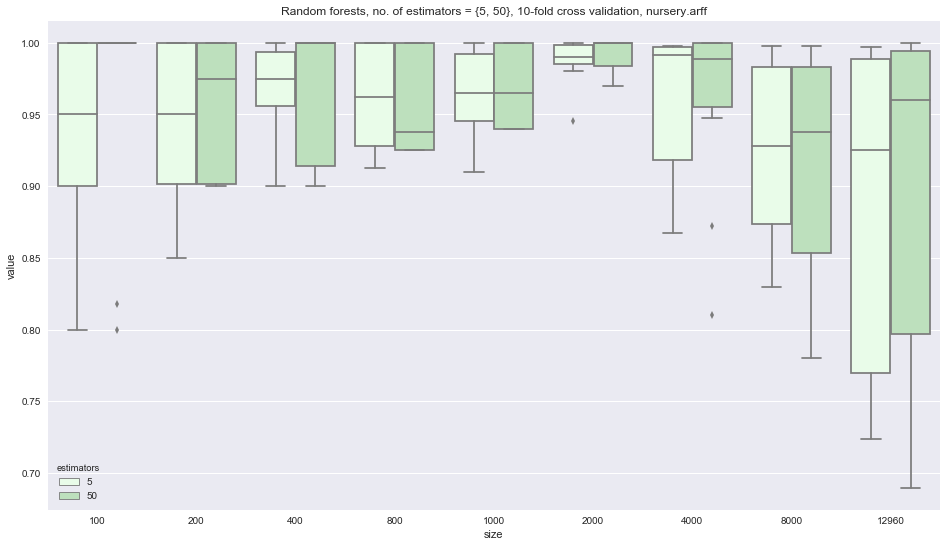

In [113]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.set_palette(sns.light_palette("green"))
sns.boxplot(x="size", y="value", hue="estimators", data=LL_df).set_title('Random forests, no. of estimators = {5, 50}, 10-fold cross validation, nursery.arff')

In [171]:
est_5_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,15.686275,14.851485,18.905473,2.992519,3.393214,2.497502,2.398801,3.299175,3.333333
MSE,15.686275,18.811881,37.810945,2.992519,4.191617,2.497502,2.398801,3.299175,3.518519
CKS,75.182482,77.451485,77.325030,94.246084,94.479258,95.338401,96.204580,95.050832,95.164191
HL,156.862745,128.712871,124.378109,29.925187,29.940120,24.975025,23.988006,32.991752,32.870370


In [173]:
est_50_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,15.686275,5.940594,7.960199,1.246883,1.796407,1.098901,1.449275,1.649588,1.080247
MSE,23.529412,7.920792,7.960199,1.246883,1.796407,1.098901,1.449275,1.649588,1.080247
CKS,81.386861,90.998217,85.135885,97.608683,96.657202,97.948316,97.713889,97.524888,98.412271
HL,117.647059,49.504950,79.601990,12.468828,17.964072,10.989011,14.492754,16.495876,10.802469


# 2. Sieci bayesowskie - porównanie algorytmów w zależności od data setu

# ! Wywołanie poniższego skryptu jest czasochłonne.

In [118]:
bn_splits = 10

BN_df = pd.DataFrame()

total = len(nursery_paths)

In [119]:
BN_K2_df = pd.DataFrame()

for i, path in enumerate(nursery_paths):
    print(i + 1, "of", total)
    value = KFoldCrossValidation(path, 8).perform_k_fold_cross_validation(10, K2Algorithm(score_method='aic', number_of_parents=2))
    df_temp = pd.DataFrame({"value": value })
    df_temp['size'] = labels[i]
    df_temp['name'] = "K2"
    BN_K2_df = BN_K2_df.append(df_temp)

1 of 9


2 of 9


3 of 9


4 of 9


5 of 9


6 of 9


7 of 9


8 of 9


9 of 9


In [120]:
BN_TAN_df = pd.DataFrame()

for i, path in enumerate(nursery_paths):
    print(i + 1, "of", total)
    value = KFoldCrossValidation(path, 8).perform_k_fold_cross_validation(10, TANAlgorithm())
    df_temp = pd.DataFrame({"value": value })
    df_temp['size'] = labels[i]
    df_temp['name'] = "TAN"
    BN_TAN_df = BN_TAN_df.append(df_temp)

1 of 9


2 of 9


3 of 9


4 of 9


5 of 9


6 of 9


7 of 9


8 of 9


9 of 9


In [ ]:
BN_TABU_df = pd.DataFrame()

for i, path in enumerate(nursery_paths):
    print(i + 1, "of", total)
    value = KFoldCrossValidation(path, 8).perform_k_fold_cross_validation(10, TabuSearch(score_method='aic', number_of_parents=2, number_of_iterations=10, tabu_length=3))
    df_temp = pd.DataFrame({"value": value })
    df_temp['size'] = labels[i]
    df_temp['name'] = "TABU"
    BN_TABU_df = BN_TABU_df.append(df_temp)

Text(0.5,1,'Bayesian networks, 10-fold cross validation, TAN/TABU/K2, nursery.arff')

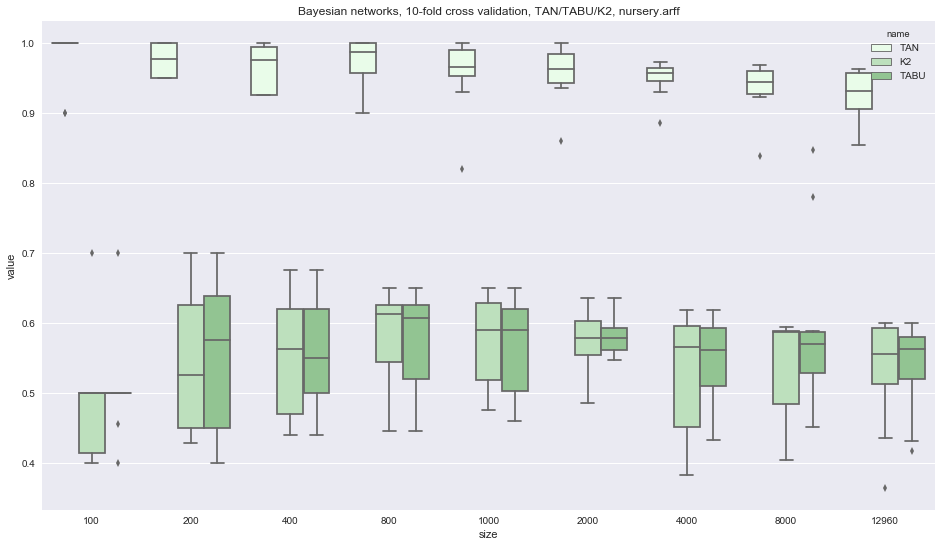

In [122]:
BN_df = pd.DataFrame()
BN_df = BN_df.append(BN_TAN_df)
BN_df = BN_df.append(BN_K2_df)
BN_df = BN_df.append(BN_TABU_df)

sns.set(rc={'figure.figsize':(16, 9)})
sns.set_palette(sns.light_palette("green"))
sns.boxplot(x="size", y="value", hue="name", data=BN_df).set_title('Bayesian networks, 10-fold cross validation, TAN/TABU/K2, nursery.arff')

In [ ]:
TAN_stats_df = ComputeBayesianNetworkStats(TANAlgorithm(), nursery_paths).compute_stats_dataframe()
K2_stats_df = ComputeBayesianNetworkStats(K2Algorithm(score_method='aic', number_of_parents=2), nursery_paths).compute_stats_dataframe()
TABU_stats_df = ComputeBayesianNetworkStats(TabuSearch(score_method='aic', number_of_parents=2, number_of_iterations=10, tabu_length=3), nursery_paths).compute_stats_dataframe()

In [151]:
TAN_stats_df[400] = [0.098333, 0.162315, 0.912343, 0.063245]
TAN_stats_df2 = TAN_stats_df.drop('test', 1)
TAN_stats_df2

,100,200,400,800,1000,2000,4000,8000,12960,400
MAE,0.095238,0.097561,0.098333,0.024845,0.039801,0.034913,0.049938,0.043723,0.038580,0.098333
MSE,0.190476,0.146341,0.162315,0.024845,0.039801,0.034913,0.049938,0.043723,0.038580,0.162315
CKS,0.931148,0.893599,0.912343,0.957204,0.929337,0.936853,0.903369,0.915771,0.925464,0.912343
HL,0.047619,0.073171,0.063245,0.024845,0.039801,0.034913,0.049938,0.043723,0.038580,0.063245


In [125]:
K2_stats_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,1.380952,1.243902,1.246914,1.136646,1.129353,1.109726,1.082397,1.079950,1.077160
MSE,3.666667,3.243902,3.296296,3.136646,3.149254,3.109726,3.087391,3.079950,3.078704
CKS,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HL,0.571429,0.560976,0.555556,0.465839,0.452736,0.441397,0.413233,0.412867,0.409722


In [126]:
TABU_stats_df

,100,200,400,800,1000,2000,4000,8000,12960
MAE,1.285714,1.268293,1.246914,1.136646,1.129353,1.109726,1.092385,1.169894,1.097222
MSE,3.285714,3.268293,3.296296,3.136646,3.149254,3.109726,3.047441,3.019988,3.063272
CKS,0.066667,0.104463,0.000000,0.000000,0.000000,0.000000,0.014299,0.000885,0.001481
HL,0.571429,0.560976,0.555556,0.465839,0.452736,0.441397,0.433208,0.517801,0.433642


# 3. Porównanie algorytmów - wykres świecowy

* SVM - kernel=rbf, bo wyszło najkorzystniej,
* BN - TAN, bo wyszedł najkorzystniej,
* KNN - k=5, bo wyszło najkorzystniej.

In [ ]:
splits = 10
seed = 7
path = nursery_paths[best_arff]

names = []
results = []
models = []
models.append(('SVM', SVC(kernel='rbf', C=50))))
models.append(('KNN', KNeighborsClassifier(5, weights='distance')))
models.append(('LL', RandomForestClassifier(n_estimators=10, criterion='entropy')))

X = data.data
y = data.target
    
for name, model in models:
    kfold = model_selection.KFold(n_splits=splits, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    
results.append(KFoldCrossValidation(nursery_paths[best_arff], 8).perform_k_fold_cross_validation(10, TANAlgorithm()))    
names.append("BN TAN")    

In [58]:
pd_SVM = pd.DataFrame({"value": results[0]})
pd_SVM['name'] = "SVM"

pd_KNN = pd.DataFrame({"value": results[1]})
pd_KNN['name'] = "KNN"

pd_LL = pd.DataFrame({"value": results[2]})
pd_LL['name'] = "LL"

pd_TAN = pd.DataFrame({"value": results[3]})
pd_TAN['name'] = "BN TAN"

COMP_df = pd.DataFrame()
COMP_df = COMP_df.append(pd_SVM)
COMP_df = COMP_df.append(pd_KNN)
COMP_df = COMP_df.append(pd_LL)
COMP_df = COMP_df.append(pd_TAN)

Text(0.5,1,'SVM/KNN/LL/BN TAN')

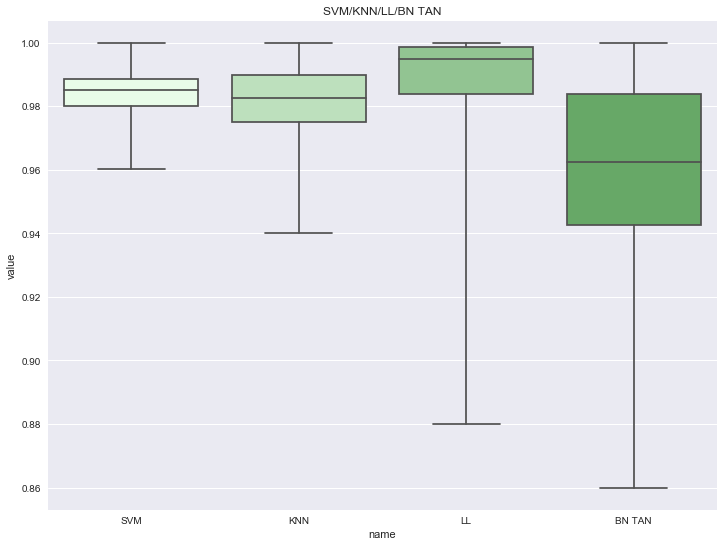

In [112]:
sns.set(rc={'figure.figsize':(12, 9)})
sns.set_palette(sns.light_palette("green"))
sns.boxplot(x="name", y="value", data=COMP_df, whis=np.inf).set_title("SVM/KNN/LL/BN TAN")

In [ ]:
class ComputeBayesianNetworkStats(object):
    def __init__(self, classifier, arff_array):
        self.classifier = classifier
        self.arff_array = arff_array
        
    def compute_stats_dataframe(self):
        bn_data = dict()
        for i, path in enumerate(self.arff_array):
            print(i)
            bn_values = self.compute_stats(path)
            bn_data[labels[i]] = bn_values
        
        return pd.DataFrame(data=bn_data, index=["MAE", "MSE", "CKS", "HL"])
        
    def compute_stats(self, 

In [98]:
est_SVM = ComputeStatisticsForArff(SVC(), path).compute_result()
est_KNN = ComputeStatisticsForArff(KNeighborsClassifier(), path).compute_result()
est_LL = ComputeStatisticsForArff(RandomForestClassifier(n_estimators=10, criterion='entropy'), path).compute_result()
est_BN = ComputeBayesianNetworkStats(TANAlgorithm(), []).compute_stats(path)

In [104]:
d = {'SVM': est_SVM, 'KNN': est_KNN, 'LL': est_LL, 'BN TAN': est_BN}
df = pd.DataFrame(data=d, index=["MAE", "MSE", "CKS", "HL"])
df = df.sort_values(['SVM', 'KNN', 'LL'])

df

,BN TAN,KNN,LL,SVM
HL,0.038580,0.042438,0.020370,0.020062
MAE,0.038580,0.051543,0.020370,0.020062
MSE,0.038580,0.085802,0.020370,0.020062
CKS,0.925464,0.937541,0.970045,0.970483


# Rozkład parametrów w zbiorze danych testowych

['not_recom', 'recommend', 'very_recom', 'priority', 'spec_prior']
[4320, 2, 328, 4266, 4044]


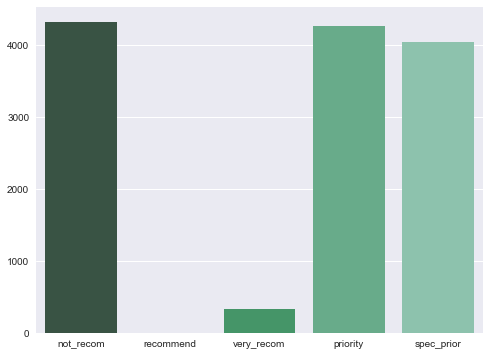

In [145]:
loading_data = load_arff('data/comparison/nursery_12960.arff')
print(loading_data.target_names)

result = [0, 0, 0, 0, 0]
for target in loading_data.target:
    result[int(target)] += 1

print(result)

sns.set(rc={'figure.figsize':(8, 6)})
sns.barplot(['not_recom', 'recommend', 'very_recom', 'priority', 'spec_prior'], result, palette="BuGn_d")

In [ ]:
sns.set(rc={'figure.figsize':(12, 9)})